<a href="https://colab.research.google.com/github/sharma18b/Image-Captioning/blob/main/Pytorch/Resnet_Attention_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/makarovartyom/Image-Captioning-with-Attention.git

Cloning into 'Image-Captioning-with-Attention'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 204 (delta 90), reused 140 (delta 42), pack-reused 0
Receiving objects: 100% (204/204), 6.79 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [3]:

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 287s 0us/step


In [4]:
import os
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = os.getcwd()
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations', 'instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations', 'instances_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=10.15s)
creating index...
index created!
loading annotations into memory...
Done (t=6.86s)
creating index...
index created!


In [6]:
print('The length of image dataset:',len(ids))

The length of image dataset: 291875


In [7]:
print('Example of an image annotation:', coco.anns[649222])

Example of an image annotation: {'segmentation': [[355.15, 138.93, 360.08, 94.54, 366.0, 78.76, 368.96, 75.8, 371.92, 74.81, 376.85, 79.74, 376.85, 92.57, 392.63, 142.88, 398.55, 169.52, 388.69, 186.29, 398.55, 207.0, 420.26, 230.68, 419.27, 266.2, 422.23, 300.72, 427.16, 318.48, 430.12, 344.13, 425.19, 353.01, 414.34, 354.98, 402.5, 345.12, 385.73, 301.71, 366.0, 235.61, 362.05, 207.99, 365.01, 199.11, 369.94, 194.18, 372.9, 190.23, 369.94, 182.34, 361.07, 176.42, 355.15, 176.42, 354.16, 166.56, 352.19, 153.73, 354.16, 142.88]], 'area': 9664.586099999999, 'iscrowd': 0, 'image_id': 222788, 'bbox': [352.19, 74.81, 77.93, 280.17], 'category_id': 42, 'id': 649222}


http://images.cocodataset.org/val2014/COCO_val2014_000000338108.jpg


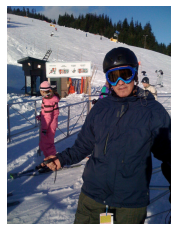

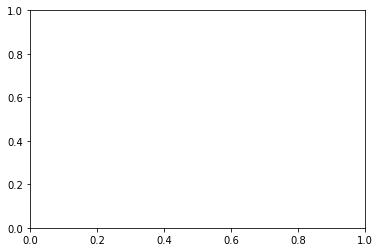

In [8]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [9]:
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    # for each color channel we pass 2 values: 
    # mean and std. deviation
    # since out image has 3 color channels, we pass 3 values for mean and  values for std. deviation
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
# we will pass 10 images at a time. So, m = 10
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=2.34s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:56<00:00, 7283.72it/s]


In [11]:
print('The shape of first image:', data_loader.dataset[0][0].shape)

The shape of first image: torch.Size([3, 224, 224])


In [12]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'
import nltk

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

sample_caption.append(data_loader.dataset.vocab(start_word))

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']
Special start word: <start>
[0]


In [13]:
print(sample_caption)

[0, 0]


In [14]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 0, 3, 98, 754, 3, 396, 39, 3, 1009, 207, 139, 3, 753, 18]


In [15]:
print('The start word is:', data_loader.dataset.vocab.start_word)
print('The end word is:', data_loader.dataset.vocab.end_word)
print('The annotations file is:', data_loader.dataset.vocab.annotations_file)

The start word is: <start>
The end word is: <end>
The annotations file is: /content/annotations/captions_train2014.json


In [16]:
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 0, 3, 98, 754, 3, 396, 39, 3, 1009, 207, 139, 3, 753, 18, 1]


In [17]:
import torch

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,    0,    3,   98,  754,    3,  396,   39,    3, 1009,  207,  139,
           3,  753,   18,    1])


In [18]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<end>': 1,
 '<start>': 0,
 '<unk>': 2,
 'a': 3,
 'and': 6,
 'clean': 5,
 'decorated': 8,
 'empty': 9,
 'very': 4,
 'well': 7}

In [19]:
print('The length of entire vocabulary is:', len(data_loader.dataset.vocab.word2idx.items()))

The length of entire vocabulary is: 8855


In [20]:
dict(list(data_loader.dataset.vocab.idx2word.items())[:10])

{0: '<start>',
 1: '<end>',
 2: '<unk>',
 3: 'a',
 4: 'very',
 5: 'clean',
 6: 'and',
 7: 'well',
 8: 'decorated',
 9: 'empty'}

In [21]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8855


In [22]:
# Modify the minimum word count threshold.
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:58<00:00, 7107.86it/s]


In [23]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9955


In [24]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


In [25]:
# nonsense words that never appear in the training captions.
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

2
2


In [26]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:56<00:00, 7287.37it/s]


In [27]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 86334
value: 11 --- count: 79948
value:  9 --- count: 71934
value: 12 --- count: 57637
value: 13 --- count: 37645
value: 14 --- count: 22335
value:  8 --- count: 20771
value: 15 --- count: 12841
value: 16 --- count:  7729
value: 17 --- count:  4842
value: 18 --- count:  3104
value: 19 --- count:  2014
value:  7 --- count:  1597
value: 20 --- count:  1451
value: 21 --- count:   999
value: 22 --- count:   683
value: 23 --- count:   534
value: 24 --- count:   383
value: 25 --- count:   277
value: 26 --- count:   215
value: 27 --- count:   159
value: 28 --- count:   115
value: 29 --- count:    86
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    39
value: 37 --- count:    32
value: 33 --- count:    31
value: 35 --- count:    31
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

In [31]:

import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
#indices = data_loader.dataset.get_indices()
#print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
#new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.

images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 11])


In [32]:
# Watch for any changes in model.py, and re-load it automatically.
#% load_ext autoreload
#% autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN()

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 49, 2048])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [35]:
print(encoder)

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [36]:

# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512
num_features = features.size(2)
#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN( num_features = num_features,
                     embedding_dim = embed_size,
                     hidden_dim = hidden_size,
                     vocab_size=vocab_size,
                    )

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
#captions = torch.tensor(captions).to(torch.int64)
captions = captions.to(device)


# Pass the encoder output and captions through the decoder.
outputs = decoder(captions = captions,
                  features = features)

print('Decoder outputs type:', type(outputs[0]))
print('Decoder outputs shape:', outputs[0].shape)

Decoder outputs type: <class 'torch.Tensor'>
Decoder outputs shape: torch.Size([10, 11, 9955])


In [37]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import sys
import os
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math

import torch.utils.data as data
from utils import get_batch_caps, get_hypothesis

import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64          # batch size, change to 64
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 14             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

log_train = 'training_log.txt'       # name of files with saved training loss and perplexity
log_val = 'validation_log.txt'
bleu = 'bleu.txt'

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr = 1e-4)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:59<00:00, 7009.54it/s]


In [38]:
# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                   # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
valid_data_loader = get_loader(transform=transform_test,
                                    batch_size=batch_size,
                         mode='valid')

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:27<00:00, 7394.63it/s]


In [39]:
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)

In [44]:
def train(epoch, 
          encoder, 
          decoder, 
          optimizer, 
          criterion, total_step, num_epochs, data_loader, write_file, save_every = 1):
    """ Train function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder
    - decoder - model's Decoder
    - optimizer - model's optimizer (Adam in our case)
    - criterion - loss function to optimize
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the training logs
    
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    
    for i_step in range(1, total_step+1):
        # training mode on
        encoder.eval() # no fine-tuning for Encoder
        decoder.train()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))
        # target captions, excluding the first word
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs, atten_weights = decoder(captions= captions_train,
                                         features = features)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
        
        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')
    
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models_new', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models_new', 'encoder-%d.pkl' % epoch))

In [41]:
def validate(epoch, 
             encoder, 
             decoder, 
             optimizer, 
             criterion, 
             total_step, num_epochs, data_loader, write_file, bleu_score_file):
    """ Validation function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder (evaluation)
    - decoder - model's Decoder (evaluation)
    - optimizer - model's optimizer (Adam in our case)
    - criterion - optimized loss function
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the validation logs
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    references = []
    hypothesis = []
      
    for i_step in range(1, total_step+1):
        # evaluation of encoder and decoder
        encoder.eval()
        decoder.eval()
        val_images, val_captions, caps_all = next(iter(data_loader))
        
        val_captions_target = val_captions[:, 1:].to(device) 
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)
    
        
        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions= val_captions,
                                         features = features_val)
        loss_val = criterion(outputs_val.view(-1, vocab_size), 
                             val_captions_target.reshape(-1))
        
        # preprocess captions and add them to the list
        caps_processed = get_batch_caps(caps_all, batch_size=batch_size)
        references.append(caps_processed)
        # get corresponding indicies from predictions
        # and form hypothesis from output
        terms_idx = torch.max(outputs_val, dim=2)[1]
        hyp_list = get_hypothesis(terms_idx, data_loader=data_loader)
        hypothesis.append(hyp_list)
        
        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex
        
        stats = 'Epoch valid: [%d/%d], Step valid: [%d/%d], Loss valid: %.4f, Perplexity valid: %5.4f' % (epoch, num_epochs, i_step, total_step, loss_val.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
            
    # prepare the proper shape for computing BLEU scores
    references = np.array(references).reshape(total_step*batch_size, -1)
    #hyps = np.array(hypothesis).reshape(total_step*batch_size, -1)
    hyps = np.concatenate(np.array(hypothesis))
        
    bleu_1 = corpus_bleu(references, hyps, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hyps, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hyps, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(references, hyps, weights = (0.25, 0.25, 0.25, 0.25))
    # append individual n_gram scores
    #bleu_score_list.append((bleu_1, bleu_2, bleu_3, bleu_4))
    
    print('\r')
    print('Epoch valid:', epoch)
    epoch_stat = 'Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f, \
    BLEU-1: %.2f, BLEU-2: %.2f, BLEU-3: %.2f, BLEU-4: %.2f' % (epoch_loss_avg, epoch_perp_avg, bleu_1, bleu_2, bleu_3, bleu_4)
    
    print('\r' + epoch_stat, end="")
    print('\r')
    
    bleu_score_file.write(epoch_stat + '\n')
    bleu_score_file.flush()

In [ ]:
CoCo

In [ ]:
# Open the training log file.
file_train = open(log_train, 'w')
file_val = open(log_val, 'w')
bleu_score_file = open(bleu, 'w')


# store BLEU scores in list 
bleu_scores = []
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
num_epochs = 3
for epoch in range(0, 2):   
    train(epoch, encoder, decoder, optimizer, criterion, total_step, num_epochs =num_epochs,
          data_loader = data_loader,
          write_file = file_train, 
          save_every = 1)
    
    validate(epoch, encoder, decoder, optimizer, criterion, 
             total_step = total_step_valid, 
             num_epochs = num_epochs, 
             data_loader = valid_data_loader, write_file=file_val, bleu_score_file=bleu_score_file)
    
file_train.close()
file_val.close()
bleu_score_file.close()

Epoch train: [0/3], Step train: [100/6471], Loss train: 5.2832, Perplexity train: 197.0028
Epoch train: [0/3], Step train: [200/6471], Loss train: 5.0426, Perplexity train: 154.8719
Epoch train: [0/3], Step train: [300/6471], Loss train: 4.6882, Perplexity train: 108.6622
Epoch train: [0/3], Step train: [400/6471], Loss train: 4.6914, Perplexity train: 109.0048
Epoch train: [0/3], Step train: [500/6471], Loss train: 4.6539, Perplexity train: 104.9951
Epoch train: [0/3], Step train: [600/6471], Loss train: 5.4521, Perplexity train: 233.2428
Epoch train: [0/3], Step train: [700/6471], Loss train: 4.5217, Perplexity train: 91.9964
Epoch train: [0/3], Step train: [800/6471], Loss train: 4.6776, Perplexity train: 107.5123
Epoch train: [0/3], Step train: [900/6471], Loss train: 4.1892, Perplexity train: 65.9716
Epoch train: [0/3], Step train: [1000/6471], Loss train: 4.3756, Perplexity train: 79.4871
Epoch train: [0/3], Step train: [1100/6471], Loss train: 4.6677, Perplexity train: 106.4496


In [ ]:
# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [ ]:
test_data_loader = get_loader(transform=transform_test,
                                    batch_size=1,
                         mode='test')

In [ ]:
vocab_size = len(test_data_loader.dataset.vocab)
vocab_size

In [ ]:
encoder_file = 'encoder-14.pkl' 
decoder_file = 'decoder-14.pkl'


embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder

# The size of the vocabulary.
vocab_size = len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)
decoder.eval()


# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models_new', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models_new', decoder_file), map_location='cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

In [ ]:
orig_image, image = next(iter(test_data_loader))

In [ ]:
print('Image shape:', list(image.size()))
print('Original image shape:', list(orig_image.size()))

In [ ]:
def clean_sentence(output, data_loader):
    vocab = data_loader.dataset.vocab.idx2word
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in (',', '.', '<end>')]
    sentence = " ".join(words)
    
    return sentence

In [ ]:
def get_prediction(data_loader):
    orig_image, image = next(iter(data_loader))
    plt.imshow(orig_image.squeeze())
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [ ]:
# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [ ]:
image = image.to(device)

# Obtain the embedded image features.
print(image.shape)
features = encoder(image)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)
assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in test_data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

In [ ]:

sentence = clean_sentence(output, test_data_loader)
print('example sentence:', sentence)

In [ ]:
import sys
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from beam_search import BeamSearch
from utils import visualize_attention

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-14.pkl' 
decoder_file = 'decoder-14.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512
num_features = 2048
vocab_size = 9955


# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models_simple', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models_simple', decoder_file), map_location='cpu'))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

In [ ]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
print(image.shape)
features = encoder(image)

# Pass the embedded image features through the model to get a predicted caption.
output, atten_weights = decoder.greedy_search(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

In [ ]:
# TODO #4: Complete the function.
def clean_sentence(output):
    vocab = data_loader.dataset.vocab.idx2word
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in ('<start>', ',', '.', '<end>')]
    sentence = " ".join(words)
    
    return sentence

In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

In [ ]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image)
    output, atten_weights = decoder.greedy_search(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [ ]:
get_prediction()

In [ ]:
get_prediction()

In [ ]:
# Beam search sampling k=3
beam = BeamSearch(decoder=decoder,
                 features = features,
                 k = 3, 
                 max_sentence =20)

In [ ]:
sent, score = beam.generate_caption()

In [ ]:
clean_sentence(sent)

In [ ]:
vocab = data_loader.dataset.vocab.idx2word
words = [vocab.get(idx) for idx in output]
words = [word for word in words if word not in ('<start>', ',', '.', '<end>')]

In [ ]:
visualize_attention(orig_image, words, atten_weights)